# NeuroGraphNet

*A graph-based deep learning framework for EEG seizure detection, designed to improve accuracy and interpretability by leveraging Graph Neural Networks (GNNs) to capture spatial and temporal brain dynamics.*

<hr />

This notebook presents **NeuroGraphNet**, a model that applies Graph Neural Networks to EEG data for seizure detection. The primary goal is to **compare the performance and interpretability of graph-based methods versus traditional deep learning approaches**. Through this comparison, we aim to demonstrate the advantages of incorporating brain connectivity information into the learning process.

**Authors**: Luca Di Bello, Guillaume André Bélissent, Abdessalem Ben Ali, Beatriz Izquierdo González

In [ ]:
# Run feature extraction on same node
import subprocess
subprocess.run('python3 ./feature_extraction.py', shell=True)

In [1]:
%load_ext autoreload
%autoreload 1
import time
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch_geometric.loader import DataLoader as GeoDataLoader
from torch.utils.data import DataLoader
from src.utils.seeder import seed_everything

# set seaborn theme
sns.set_theme()

# create useful constants
RANDOM_SEED = 42
IS_SCITAS = True # set to True if running on SCITAS cluster
LOCAL_DATA_ROOT = Path("./data")
DATA_ROOT = Path("/home/ogut/data") if IS_SCITAS else LOCAL_DATA_ROOT
CHECKPOINT_ROOT = Path("./.checkpoints")
SUBMISSION_ROOT = Path("./.submissions")

# create directories if they do not exist
CHECKPOINT_ROOT.mkdir(parents=True, exist_ok=True)
SUBMISSION_ROOT.mkdir(parents=True, exist_ok=True)

# set dataset root
seed_everything(RANDOM_SEED)

# setup torch device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


## Load clips

In [2]:
from src.utils.signal import time_filtering, normalize
%aimport src.utils.signal
from src.utils.index import ensure_eeg_multiindex

start = time.time()
print("⏳ Loading EEG segment tables…")
clips_tr = pd.read_parquet(DATA_ROOT / "train" / "segments.parquet").dropna()
clips_te = pd.read_parquet(DATA_ROOT / "test" / "segments.parquet").dropna()

# load clips with label
clips_tr = ensure_eeg_multiindex(clips_tr, id_col_name='id')
clips_te = ensure_eeg_multiindex(clips_te, id_col_name='id')

print(f"✔️ Loaded: {len(clips_tr)} train rows, {len(clips_te)} test rows "
      f"(took {time.time()-start:.1f}s)")
# NOTE: Merge clips for sanity checks
clips = pd.concat([clips_tr, clips_te]).reset_index()

⏳ Loading EEG segment tables…
✔️ Loaded: 12993 train rows, 3614 test rows (took 0.2s)


## Load features

In [3]:
# print feature shapes
X_train = np.load(LOCAL_DATA_ROOT / "extracted_features" / "X_train.npy", allow_pickle=True)
X_test = np.load(LOCAL_DATA_ROOT / "extracted_features" / "X_test.npy", allow_pickle=True)
y_train = np.load(LOCAL_DATA_ROOT / "labels" / "y_train.npy", allow_pickle=True)
sample_subject_array = np.load(LOCAL_DATA_ROOT / "extracted_features" / "sample_subject_array_train.npy",allow_pickle=True)

# sanity checks to ensure validity of the data
assert X_train.shape[0]  == y_train.shape[0], "Mismatch in number of training samples and labels"
assert X_train.shape[1] == X_test.shape[1], "Mismatch in number of features between train and test sets"
assert clips_tr.shape[0] == y_train.shape[0], "Mismatch in number of training samples and segments"
assert X_train.shape[0] == sample_subject_array.shape[0], "Mismatch in number of training samples and subjects"
assert clips_tr.shape[0] == sample_subject_array.shape[0], "Mismatch in number of training segments and subjects"

print("Train extracted features shape:", X_train.shape)
print("Test extracted features shape:", X_test.shape)

Train extracted features shape: (12993, 228)
Test extracted features shape: (3614, 228)


In [4]:
# ------------------------------- Extracted features -----------------------------------------------#
channels = ['FP1', 'FP2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'FZ', 'CZ', 'PZ']
features = [
    "rms", "linelen", "hj_mob", "hj_cmp", "spec_ent",
    "alpha_pow", "beta_pow", "theta_pow", "gamma_pow",
    "rel_alpha", "rel_theta", "theta_alpha_ratio"
]
n_features = len(features)
n_channels = len(channels)

feature_names = [f"{ch} - {ft}" for ch in channels for ft in features]

## Load embeddings (WORK IN PROGRESS)

## Creating timeseries dataset

In [5]:
%aimport src.utils.timeseries_eeg_dataset
from src.utils.timeseries_eeg_dataset import TimeseriesEEGDataset

LOCAL_DATA_ROOT = Path("./data")

timeseries_datasets_tr = {
    "signal": TimeseriesEEGDataset(
        root=str(LOCAL_DATA_ROOT / "timeseries_dataset_train_signal"),
        signal_folder=str(DATA_ROOT / 'train'),
        clips_df=clips_tr,
        mode='signal',
    ),
    "feature": TimeseriesEEGDataset(
        root=str(LOCAL_DATA_ROOT / "timeseries_dataset_train_features"),
        signal_folder=str(DATA_ROOT / 'train'),
        clips_df=clips_tr,
        mode='feature',
        feature_file_path=str(LOCAL_DATA_ROOT / "extracted_features" / "X_train.npy"),
    ),
    # FIXME: Uncomment the embedding dataset as soon as the embedding file is available
    # "embedding": TimeseriesEEGDataset(
    #     root=str(LOCAL_DATA_ROOT / "timeseries_dataset_train_embedding"),
    #     signal_folder=str(DATA_ROOT / 'train'),
    #     clips_df=clips_tr,
    #     mode='embedding',
    #     embedding_file_path=str(LOCAL_DATA_ROOT / "embeddings" / "X_train_embedding.npy"),
    #     labels_for_embedding_file_path=str(LOCAL_DATA_ROOT / "labels" / "y_train.npy")
    # ),
}

timeseries_datasets_te = {
    "signal": TimeseriesEEGDataset(
        root=str(LOCAL_DATA_ROOT / "timeseries_dataset_test_signal"),
        signal_folder=str(DATA_ROOT / 'test'),
        clips_df=clips_te,
        mode='signal',
    ),
    "feature": TimeseriesEEGDataset(
        root=str(LOCAL_DATA_ROOT / "timeseries_dataset_test_features"),
        signal_folder=str(DATA_ROOT / 'test'),
        clips_df=clips_te,
        mode='feature',
        feature_file_path=str(LOCAL_DATA_ROOT / "extracted_features" / "X_test.npy"),
    ),
    # FIXME: Uncomment the embedding dataset as soon as the embedding file is available
    # "embedding": TimeseriesEEGDataset(
    #     root=str(LOCAL_DATA_ROOT / "timeseries_dataset_test_embedding"),
    #     signal_folder=str(DATA_ROOT / 'test'),
    #     clips_df=clips_te,
    #     mode='embedding',
    #     embedding_file_path=str(LOCAL_DATA_ROOT / "embeddings" / "X_test_embedding.npy"),
    #     labels_for_embedding_file_path=str(LOCAL_DATA_ROOT / "labels" / "y_test.npy")
    # ),
}

🚀 Initializing TimeseriesEEGDataset in SIGNAL mode.
   - Sampling rate: 250 Hz
   - Derived segment length: 3000 timesteps.
   - Segment length: 3000 timesteps.
   ✅ Using existing cached data from data/timeseries_dataset_train_signal/processed
🏁 TimeseriesEEGDataset initialization complete. Loaded 12993 samples.
🚀 Initializing TimeseriesEEGDataset in FEATURE mode.
   ✅ Using existing cached data from data/timeseries_dataset_train_features/processed
🏁 TimeseriesEEGDataset initialization complete. Loaded 12993 samples.
🚀 Initializing TimeseriesEEGDataset in SIGNAL mode.
   - Sampling rate: 250 Hz
   - Derived segment length: 3000 timesteps.
   - Segment length: 3000 timesteps.
   ⚠️ Info: Column 'label' not found in clips_df. Processing without labels (e.g., test set).
   ✅ Using existing cached data from data/timeseries_dataset_test_signal/processed
🏁 TimeseriesEEGDataset initialization complete. Loaded 3614 samples.
🚀 Initializing TimeseriesEEGDataset in FEATURE mode.
   ⚠️ Info: Colu

## Creating graph dataset

In [6]:
from src.utils.graph_eeg_dataset import GraphEEGDataset

LOCAL_DATA_ROOT = Path("./data")

graph_datasets_tr = {
    'full': GraphEEGDataset(
        root=str(LOCAL_DATA_ROOT / 'graph_dataset_train'),
        clips_df=clips_tr,
        signal_folder=str(DATA_ROOT / 'train'),
        extracted_features_array=X_train,
        use_extracted_features=True,
        edge_strategy='full',
        spatial_distance_file=str(LOCAL_DATA_ROOT / 'distances_3d.csv'),
        force_reprocess=False,
        prefetch_data=False,
    ),
    'spatial': GraphEEGDataset(
        root=str(LOCAL_DATA_ROOT / 'graph_dataset_train'),
        clips_df=clips_tr,
        signal_folder=str(DATA_ROOT / 'train'),
        extracted_features_array=X_train,
        use_extracted_features=True,
        edge_strategy='spatial',
        spatial_distance_file=str(LOCAL_DATA_ROOT / 'distances_3d.csv'),
        force_reprocess=False,
        prefetch_data=False,
    ),
    'correlation': GraphEEGDataset(
        root=str(LOCAL_DATA_ROOT / 'graph_dataset_train'),
        clips_df=clips_tr,
        signal_folder=str(DATA_ROOT / 'train'),
        extracted_features_array=X_train,
        use_extracted_features=True,
        edge_strategy='spatial',
        spatial_distance_file=str(LOCAL_DATA_ROOT / 'distances_3d.csv'),
        force_reprocess=False,
        prefetch_data=False,
    ),
}

graph_datasets_te = {
    'full': GraphEEGDataset(
        root=str(LOCAL_DATA_ROOT / 'graph_dataset_test'),
        clips_df=clips_te,
        signal_folder=str(DATA_ROOT / 'test'),
        extracted_features_array=X_test,
        use_extracted_features=True,
        edge_strategy='full',
        spatial_distance_file=str(LOCAL_DATA_ROOT / 'distances_3d.csv'),
        force_reprocess=False, # Force reprocess for test dataset
        prefetch_data=False,
    ),
    'spatial': GraphEEGDataset(
        root=str(LOCAL_DATA_ROOT / 'graph_dataset_test'),
        clips_df=clips_te,
        signal_folder=str(DATA_ROOT / 'test'),
        extracted_features_array=X_test,
        use_extracted_features=True,
        edge_strategy='spatial',
        spatial_distance_file=str(LOCAL_DATA_ROOT / 'distances_3d.csv'),
        force_reprocess=False, # Force reprocess for test dataset
        prefetch_data=False,
    ),
    'correlation': GraphEEGDataset(
        root=str(LOCAL_DATA_ROOT / 'graph_dataset_test'),
        clips_df=clips_te,
        signal_folder=str(DATA_ROOT / 'test'),
        extracted_features_array=X_test,
        use_extracted_features=True,
        edge_strategy='correlation',
        spatial_distance_file=str(LOCAL_DATA_ROOT / 'distances_3d.csv'),
        force_reprocess=False, # Force reprocess for test dataset
        prefetch_data=False,
    )
}

print("Graph training datasets created:")
for key, ds in graph_datasets_tr.items():
    print(f"  {key}: {ds} (length: {len(ds)})")
    if len(ds) > 0:
        sample = ds[0]
        print(f"    First training sample: {sample}")

print("\nGraph test datasets created:")
for key, ds in graph_datasets_te.items():
    print(f"  {key}: {ds} (length: {len(ds)})")
    if len(ds) > 0:
        sample = ds[0]
        print(f"    First test sample: {sample}, Label (y): {getattr(sample, 'y', None)}")

🚀 Initializing GraphEEGDataset in FEATURE mode.
   - Root: data/graph_dataset_train
   - Mode: FEATURE
   - Edge strategy: full
   - Node Feature Normalization: True
⚙️ process() called for FEATURE mode. Target processed directory: data/graph_dataset_train/processed
   - Starting processing from pre-extracted features...
   - Total feature sets to process: 12993


Processing...


     - Processing feature item 1299/12993...
     - Processing feature item 2598/12993...
     - Processing feature item 3897/12993...
     - Processing feature item 5196/12993...
     - Processing feature item 6495/12993...
     - Processing feature item 7794/12993...
     - Processing feature item 9093/12993...
     - Processing feature item 10392/12993...
     - Processing feature item 11691/12993...
     - Processing feature item 12990/12993...
     - Processing feature item 12993/12993...
   ✅ Processed and saved 12993 items from features.
🏁 process() finished. Total items processed and saved in this run for feature mode: 12993
   - Found 12993 existing processed files for feature mode.
🏁 GraphEEGDataset initialization complete. Current mode: FEATURE. Known processed items: 12993
🚀 Initializing GraphEEGDataset in FEATURE mode.
   - Root: data/graph_dataset_train
   - Mode: FEATURE
   - Edge strategy: spatial
   - Node Feature Normalization: True
   - Loading spatial distances...
 

Done!
Processing...


     - Processing feature item 1299/12993...
     - Processing feature item 2598/12993...
     - Processing feature item 3897/12993...
     - Processing feature item 5196/12993...
     - Processing feature item 6495/12993...
     - Processing feature item 7794/12993...
     - Processing feature item 9093/12993...
     - Processing feature item 10392/12993...
     - Processing feature item 11691/12993...
     - Processing feature item 12990/12993...
     - Processing feature item 12993/12993...
   ✅ Processed and saved 12993 items from features.
🏁 process() finished. Total items processed and saved in this run for feature mode: 12993
   - Found 12993 existing processed files for feature mode.
🏁 GraphEEGDataset initialization complete. Current mode: FEATURE. Known processed items: 12993
🚀 Initializing GraphEEGDataset in FEATURE mode.
   - Root: data/graph_dataset_train
   - Mode: FEATURE
   - Edge strategy: spatial
   - Node Feature Normalization: True
   - Loading spatial distances...
 

Done!
Processing...


     - Processing feature item 1299/12993...
     - Processing feature item 2598/12993...
     - Processing feature item 3897/12993...
     - Processing feature item 5196/12993...
     - Processing feature item 6495/12993...
     - Processing feature item 7794/12993...
     - Processing feature item 9093/12993...
     - Processing feature item 10392/12993...
     - Processing feature item 11691/12993...
     - Processing feature item 12990/12993...
     - Processing feature item 12993/12993...
   ✅ Processed and saved 12993 items from features.
🏁 process() finished. Total items processed and saved in this run for feature mode: 12993
   - Found 12993 existing processed files for feature mode.
🏁 GraphEEGDataset initialization complete. Current mode: FEATURE. Known processed items: 12993
🚀 Initializing GraphEEGDataset in FEATURE mode.
   - Root: data/graph_dataset_test
   - Mode: FEATURE
   - Edge strategy: full
   - Node Feature Normalization: True
⚙️ process() called for FEATURE mode. T

Done!
Processing...


     - Processing feature item 361/3614...
     - Processing feature item 722/3614...
     - Processing feature item 1083/3614...
     - Processing feature item 1444/3614...
     - Processing feature item 1805/3614...
     - Processing feature item 2166/3614...
     - Processing feature item 2527/3614...
     - Processing feature item 2888/3614...
     - Processing feature item 3249/3614...
     - Processing feature item 3610/3614...
     - Processing feature item 3614/3614...
   ✅ Processed and saved 3614 items from features.
🏁 process() finished. Total items processed and saved in this run for feature mode: 3614
   - Found 3614 existing processed files for feature mode.
🏁 GraphEEGDataset initialization complete. Current mode: FEATURE. Known processed items: 3614
🚀 Initializing GraphEEGDataset in FEATURE mode.
   - Root: data/graph_dataset_test
   - Mode: FEATURE
   - Edge strategy: spatial
   - Node Feature Normalization: True
   - Loading spatial distances...
     - Loaded 180 uniqu

Done!
Processing...


     - Processing feature item 361/3614...
     - Processing feature item 722/3614...
     - Processing feature item 1083/3614...
     - Processing feature item 1444/3614...
     - Processing feature item 1805/3614...
     - Processing feature item 2166/3614...
     - Processing feature item 2527/3614...
     - Processing feature item 2888/3614...
     - Processing feature item 3249/3614...
     - Processing feature item 3610/3614...
     - Processing feature item 3614/3614...
   ✅ Processed and saved 3614 items from features.
🏁 process() finished. Total items processed and saved in this run for feature mode: 3614
   - Found 3614 existing processed files for feature mode.
🏁 GraphEEGDataset initialization complete. Current mode: FEATURE. Known processed items: 3614
🚀 Initializing GraphEEGDataset in FEATURE mode.
   - Root: data/graph_dataset_test
   - Mode: FEATURE
   - Edge strategy: correlation
   - Node Feature Normalization: True
⚙️ process() called for FEATURE mode. Target processe

Done!
Processing...
/home/ldibello/venvs/neuro/lib/python3.10/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]


     - Processing feature item 361/3614...
     - Processing feature item 722/3614...
     - Processing feature item 1083/3614...
     - Processing feature item 1444/3614...
     - Processing feature item 1805/3614...
     - Processing feature item 2166/3614...
     - Processing feature item 2527/3614...
     - Processing feature item 2888/3614...
     - Processing feature item 3249/3614...
     - Processing feature item 3610/3614...
     - Processing feature item 3614/3614...
   ✅ Processed and saved 3614 items from features.
🏁 process() finished. Total items processed and saved in this run for feature mode: 3614
   - Found 3614 existing processed files for feature mode.
🏁 GraphEEGDataset initialization complete. Current mode: FEATURE. Known processed items: 3614
Graph training datasets created:
  full: GraphEEGDataset(12993) (length: 12993)
     INFO: Attempting torch.load with weights_only=False for data/graph_dataset_train/processed/data_feat_0.pt
    First training sample: Data(x=

Done!


## Timeseries datasets train-validation splits

In [7]:
from torch.utils.data import random_split

# split training dataset into train/val sets if not already done
TRAIN_RATIO = 0.8
TIMESERIES_TRAIN_SIZE = int(len(timeseries_datasets_tr["signal"]) * TRAIN_RATIO)
TIMESERIES_VAL_SIZE = len(timeseries_datasets_tr["signal"]) - TIMESERIES_TRAIN_SIZE

# Store original datasets before reassigning
original_timeseries_datasets_tr = timeseries_datasets_tr.copy()

# Split each training (both timeseries and graph) dataset into train/val
timeseries_datasets_tr = {}
timeseries_datasets_val = {}
for key, ds in original_timeseries_datasets_tr.items():
    tr, val = random_split(ds, [TIMESERIES_TRAIN_SIZE, TIMESERIES_VAL_SIZE], generator=torch.Generator().manual_seed(RANDOM_SEED))
    timeseries_datasets_tr[key] = tr
    timeseries_datasets_val[key] = val
    print(f"{key}: Train size = {len(tr)}, Val size = {len(val)}")
print(timeseries_datasets_tr)
print(timeseries_datasets_val)
print(timeseries_datasets_te)

signal: Train size = 10394, Val size = 2599
feature: Train size = 10394, Val size = 2599
{'signal': <torch.utils.data.dataset.Subset object at 0x7f8422b2a470>, 'feature': <torch.utils.data.dataset.Subset object at 0x7f8422b2a1d0>}
{'signal': <torch.utils.data.dataset.Subset object at 0x7f8422b28ee0>, 'feature': <torch.utils.data.dataset.Subset object at 0x7f8422b2b370>}
{'signal': <src.utils.timeseries_eeg_dataset.TimeseriesEEGDataset object at 0x7f8665b85060>, 'feature': <src.utils.timeseries_eeg_dataset.TimeseriesEEGDataset object at 0x7f8665b85ab0>}


## Graph datasets train-validation splits

In [8]:
from torch.utils.data import random_split

# split training dataset into train/val sets if not already done
TRAIN_RATIO = 0.8
GRAPH_TRAIN_SIZE = int(len(graph_datasets_tr["full"]) * TRAIN_RATIO)
GRAPH_VAL_SIZE = len(graph_datasets_tr["full"]) - GRAPH_TRAIN_SIZE

# Store original datasets before reassigning
original_graph_datasets_tr = graph_datasets_tr

# Split each training (both timeseries and graph) dataset into train/val
graph_datasets_tr = {}
graph_datasets_val = {}
for key, ds in original_graph_datasets_tr.items():
    tr, val = random_split(ds, [GRAPH_TRAIN_SIZE, GRAPH_VAL_SIZE], generator=torch.Generator().manual_seed(RANDOM_SEED))
    graph_datasets_tr[key] = tr
    graph_datasets_val[key] = val
    print(f"{key}: Train size = {len(tr)}, Val size = {len(val)}")
print(graph_datasets_tr)
print(graph_datasets_val)
print(graph_datasets_te)

full: Train size = 10394, Val size = 2599
spatial: Train size = 10394, Val size = 2599
correlation: Train size = 10394, Val size = 2599
{'full': <torch.utils.data.dataset.Subset object at 0x7f84281d0f70>, 'spatial': <torch.utils.data.dataset.Subset object at 0x7f8422b2a8c0>, 'correlation': <torch.utils.data.dataset.Subset object at 0x7f8422b2b520>}
{'full': <torch.utils.data.dataset.Subset object at 0x7f8422b28f40>, 'spatial': <torch.utils.data.dataset.Subset object at 0x7f8422b28f70>, 'correlation': <torch.utils.data.dataset.Subset object at 0x7f8422b2ae90>}
{'full': GraphEEGDataset(3614), 'spatial': GraphEEGDataset(3614), 'correlation': GraphEEGDataset(3614)}


In [9]:
# Create DataLoaders for both timeseries and graph datasets
common_loader_kwargs = dict(
    batch_size=512,
    num_workers=16,
    persistent_workers=True,
    pin_memory=True,
    prefetch_factor=8,
)

dl_start = time.time()
timeseries_loader_tr= {}
timeseries_loader_val = {}
timeseries_loader_te = {}
print("⏳ Creating Timeseries DataLoaders…")
for kind in timeseries_datasets_tr.keys():
    timeseries_loader_tr[kind] = DataLoader(timeseries_datasets_tr[kind], shuffle=True,  **common_loader_kwargs) # type: ignore
    timeseries_loader_val[kind]   = DataLoader(timeseries_datasets_val[kind], shuffle=False, **common_loader_kwargs) # type: ignore
    timeseries_loader_te[kind]  = DataLoader(timeseries_datasets_te[kind], shuffle=False, **common_loader_kwargs) # type: ignore
    print(f"\t  {kind}: Train loader size = {len(timeseries_loader_tr[kind])}, "
            f"Val loader size = {len(timeseries_loader_val[kind])}, "
            f"Test loader size = {len(timeseries_loader_te[kind])}")
print(f"✔️ DataLoaders created in {time.time() - dl_start:.1f}s")

dl_start = time.time()
graph_loader_tr= {}
graph_loader_val = {}
graph_loader_te = {}
print("⏳ Creating Graph DataLoaders…")
for kind in graph_datasets_tr.keys():
    graph_loader_tr[kind] = GeoDataLoader(graph_datasets_tr[kind], shuffle=True,  **common_loader_kwargs) # type: ignore
    graph_loader_val[kind]   = GeoDataLoader(graph_datasets_val[kind], shuffle=False, **common_loader_kwargs) # type: ignore
    graph_loader_te[kind]  = GeoDataLoader(graph_datasets_te[kind], shuffle=False, **common_loader_kwargs) # type: ignore
    print(f"\t  {kind}: Train loader size = {len(graph_loader_tr[kind])}, "
            f"Val loader size = {len(graph_loader_val[kind])}, "
            f"Test loader size = {len(graph_loader_te[kind])}")
print(f"✔️ GeoDataLoaders created in {time.time() - dl_start:.1f}s")

⏳ Creating Timeseries DataLoaders…
	  signal: Train loader size = 21, Val loader size = 6, Test loader size = 8
	  feature: Train loader size = 21, Val loader size = 6, Test loader size = 8
✔️ DataLoaders created in 0.0s
⏳ Creating Graph DataLoaders…
	  full: Train loader size = 21, Val loader size = 6, Test loader size = 8
	  spatial: Train loader size = 21, Val loader size = 6, Test loader size = 8
	  correlation: Train loader size = 21, Val loader size = 6, Test loader size = 8
✔️ GeoDataLoaders created in 0.0s


In [10]:
for batch in timeseries_loader_tr['signal']:
    # Print batch shape and type
    print(f"Batch type: {type(batch)}")
    print(f"Batch length: {len(batch)}")
    print(batch[0].shape)    
    print(batch[1].shape)
    break

Batch type: <class 'list'>
Batch length: 2
torch.Size([512, 19, 3000])
torch.Size([512, 1])


## Traditional approaches (no additional features)

In [10]:
from src.utils.train import train_model, evaluate_model
from src.utils.plot import plot_training_loss

## 0. MLP

In [16]:
%aimport
from src.layers.simple_mlp import SimpleMLP

# build model with current parameters
model = SimpleMLP(
    input_dim=228,
    hidden_dims=[256, 128],
    dropout=0.3,
    num_classes=1
)
if torch.cuda.device_count() > 1:
    print(f"Using {torch.cuda.device_count()} GPUs for this combination.")
    model = nn.DataParallel(model)
model = model.to(device)

criterion = nn.BCEWithLogitsLoss()  # Assuming this remains constant
optimizer = optim.Adam(model.parameters(), lr=3e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.5)

Modules to reload:
src.utils.signal src.utils.timeseries_eeg_dataset

Modules to skip:



In [17]:
%aimport
SIMPLE_MLP_SAVE_PATH = CHECKPOINT_ROOT / "simple_mlp_best_model.pt"
SIMPLE_MLP_SUBMISSION_PATH = SUBMISSION_ROOT / "simple_mlp_submission.csv"

# train model on training set (or load existing)
train_history, val_history = train_model(
        model, timeseries_loader_tr["feature"], timeseries_loader_val["feature"],
        criterion, optimizer, device,
        save_path=SIMPLE_MLP_SAVE_PATH,
        num_epochs=300,
        patience=10,
        scheduler=scheduler,
        overwrite=True,
        use_gnn=False,
        use_oversampling=True,
    )

Modules to reload:
src.utils.signal src.utils.timeseries_eeg_dataset

Modules to skip:

🔍 Applying oversampling to the training data...
  Attribute-based label extraction not applicable or failed. Iterating through 10394 dataset samples...


  Finished iterating. Collected 10394 labels.
  Class counts before oversampling: [8375, 2019]
  Successfully created an oversampled DataLoader.
💪 Starting training from epoch 1 to 300...


Epochs:   0%|▎                                                                                  | 1/300 [00:00<?, ?it/s]


RuntimeError: mat1 and mat2 shapes cannot be multiplied (512x665 and 228x256)

## 0. Feature Net

In [58]:
%aimport
from src.layers.feature_net import FeatureNet

# build model with current parameters
model = FeatureNet(
    input_dim=665,
    hidden_dims=[512, 256, 128],
    dropout=0.3,
    num_classes=1
)
if torch.cuda.device_count() > 1:
    print(f"Using {torch.cuda.device_count()} GPUs for this combination.")
    model = nn.DataParallel(model)
model = model.to(device)

criterion = nn.BCEWithLogitsLoss()  # Assuming this remains constant
optimizer = optim.Adam(model.parameters(), lr=3e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.5)

Modules to reload:
src.layers.lstm src.utils.signal src.utils.timeseries_eeg_dataset src.utils.train

Modules to skip:



In [ ]:
%aimport
FEATURE_NET_SAVE_PATH = CHECKPOINT_ROOT / "feature_net_best_model.pt"
FEATURE_NET_SUBMISSION_PATH = SUBMISSION_ROOT / "feature_net_submission.csv"

train_history, val_history = train_model(
        model, timeseries_loader_tr["feature"], timeseries_loader_val["feature"],
        criterion, optimizer, device,
        save_path=FEATURE_NET_SAVE_PATH,
        num_epochs=300,
        patience=10,
        scheduler=scheduler,
        overwrite=True,
        use_gnn=False,
        use_oversampling=True,
    )

Modules to reload:
src.layers.lstm src.utils.signal src.utils.timeseries_eeg_dataset src.utils.train

Modules to skip:

   Using WeightedRandomSampler for oversampling. BCEWithLogitsLoss will not use explicit pos_weight.
🔍 Applying oversampling to the training data...
Original train dataset: <torch.utils.data.dataset.Subset object at 0x7f06582f5570>
Index 0 (tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.,

KeyboardInterrupt: 

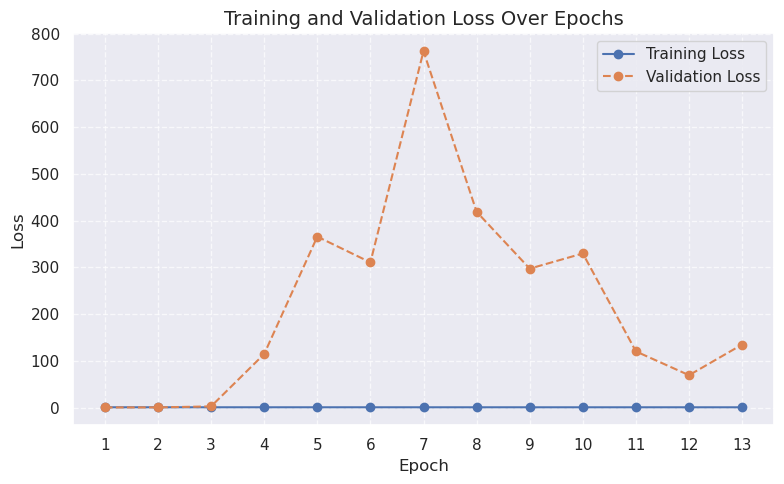

In [42]:
# plot train and val loss
plot_training_loss(train_history["loss"], val_history["loss"])

In [15]:
FEATURE_NET_SAVE_PATH = CHECKPOINT_ROOT / "feature_net_best_model.pt"
FEATURE_NET_SUBMISSION_PATH = SUBMISSION_ROOT / "feature_net_submission.csv"

# train model on training set (or load existing)
train_history, val_history = train_model(
        model, timeseries_loader_tr["feature"], timeseries_loader_val["feature"],
        criterion, optimizer, device,
        save_path=FEATURE_NET_SAVE_PATH,
        num_epochs=300,
        patience=10,
        scheduler=scheduler,
        overwrite=True,
        use_gnn=False,
        use_oversampling=True,
    )

🔍 Applying oversampling to the training data...
  Attribute-based label extraction not applicable or failed. Iterating through 10394 dataset samples...


  Finished iterating. Collected 10394 labels.
  Class counts before oversampling: [8375, 2019]
  Successfully created an oversampled DataLoader.
💪 Starting training from epoch 1 to 300...


Epochs:   0%|▎                                                                                  | 1/300 [00:00<?, ?it/s]


AttributeError: 'tuple' object has no attribute 'size'

### 1. LSTM classifier (baseline)

**Signal**

In [61]:
%aimport src.layers.lstm
from src.layers.lstm import LSTM

# build model with current parameters
lstm_model = LSTM(input_dim=19,
                hidden_dim=64,
                num_layers=4,
                dropout=0.3, input_type="signal")
if torch.cuda.device_count() > 1:
    print(f"Using {torch.cuda.device_count()} GPUs for this combination.")
    lstm_model = nn.DataParallel(lstm_model)
lstm_model = lstm_model.to(device)

criterion = nn.BCEWithLogitsLoss()  # Assuming this remains constant
optimizer = optim.Adam(lstm_model.parameters(), lr=3e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.5)

In [64]:
LSTM_SAVE_PATH = CHECKPOINT_ROOT / "lstm_signal_best_model.pt"
LSTM_SUBMISSION_PATH = SUBMISSION_ROOT / "lstm_signal_submission.csv"

# train model on training set (or load existing)
train_history, val_history = train_model(
        model=lstm_model,
        train_loader=timeseries_loader_tr["signal"],
        val_loader=timeseries_loader_val["signal"],
        criterion=nn.BCEWithLogitsLoss(),
        optimizer=optimizer,
        device=device,
        num_epochs=100,
        use_oversampling=True,
    )

   Using WeightedRandomSampler for oversampling. BCEWithLogitsLoss will not use explicit pos_weight.
🔍 Applying oversampling to the training data...


AttributeError: 'Subset' object has no attribute 'columns'

### 2. Bidirectional LSTM with early stopping

**Features**

In [36]:
%aimport src.layers.lstm
from src.layers.lstm import LSTM

# build model with current parameters
lstm_model = LSTM(input_dim=665,
                hidden_dim=64,
                num_layers=4,
                dropout=0.1,
                bidirectional=True)
if torch.cuda.device_count() > 1:
    print(f"Using {torch.cuda.device_count()} GPUs for this combination.")
    lstm_model = nn.DataParallel(lstm_model)
lstm_model = lstm_model.to(device)

criterion = nn.BCEWithLogitsLoss()  # Assuming this remains constant
optimizer = optim.Adam(lstm_model.parameters(), lr=3e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.5)

In [39]:
BI_LSTM_SAVE_PATH = CHECKPOINT_ROOT / "bi_lstm_feature_best_model.pt"
BI_LSTM_SUBMISSION_PATH = SUBMISSION_ROOT / "bi_lstm_feature_submission.csv"

# train model on training set (or load existing)
train_history, val_history = train_model(
        lstm_model, timeseries_loader_tr["feature"], timeseries_loader_val["feature"],
        criterion, optimizer, device,
        save_path=BI_LSTM_SAVE_PATH,
        num_epochs=300,
        patience=10,
        scheduler=scheduler,
        overwrite=False,
        use_gnn=False
    )

🚀 Attempting to load checkpoint from .checkpoints/bi_lstm_feature_best_model.pt...
   - Loading checkpoint from: .checkpoints/bi_lstm_feature_best_model.pt
   - Detected full checkpoint dictionary.
   - Optimizer state loaded from checkpoint.
   - Model state successfully loaded.
 ✅ Checkpoint loaded. Resuming from epoch 2. Best 'val_loss' score: 0.0000
💪 Starting training from epoch 2 to 300...


Epochs:  34%|▎| 101/300 [00:52<01:46,  1.87it/s, train_loss=0.4942, val_loss=0.4450, best_val_loss=0.0000, lr=1.83e-08, 

🛑 Early stopping: no 'val_loss' improvement in 100 epochs.

✅ Training complete.
↩️ Loading best model state from .checkpoints/bi_lstm_feature_best_model.pt for return.


In [ ]:
plot_training_loss(train_history["loss"], val_history["loss"], "BiLSTM [Features]")

In [ ]:
%aimport src.utils.train
from src.utils.train import evaluate_model
# evaluate model on test set and generate submission file
evaluate_model(
    lstm_model, timeseries_loader_te["feature"], device,
    checkpoint_path=BI_LSTM_SAVE_PATH,
    submission_path=BI_LSTM_SUBMISSION_PATH,
    use_gnn=False,
    input_type="feature",
)

**Features + Oversampling**

In [ ]:
BI_LSTM_SAVE_PATH = CHECKPOINT_ROOT / "bi_lstm_feature_best_model.pt"
BI_LSTM_SUBMISSION_PATH = SUBMISSION_ROOT / "bi_lstm_feature_submission.csv"

# train model on training set (or load existing)
train_history, val_history = train_model(
    lstm_model, timeseries_loader_tr["feature"], timeseries_loader_val["feature"],
    criterion, optimizer, device,
    save_path=BI_LSTM_SAVE_PATH,
    num_epochs=300,
    patience=10,
    monitor="val_loss",
    scheduler=scheduler,
    overwrite=False,
    use_gnn=False,
    use_oversampling=True,
)

### 3. LSTM with Attention and early stopping

**Features**

In [45]:
%aimport src.layers.lstm
from src.layers.lstm import LSTMAttention

# Create model and fit it
attention_lstm_model = LSTMAttention(input_dim=665, hidden_dim=64, num_layers=3, dropout=0.2, input_type="feature")
if torch.cuda.device_count() > 1:
    print(f"Using {torch.cuda.device_count()} GPUs")
    attention_lstm_model = nn.DataParallel(attention_lstm_model)
attention_lstm_model = attention_lstm_model.to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(attention_lstm_model.parameters(), lr=1e-3, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.5)

In [46]:
ATTENTION_LSTM_SAVE_PATH = CHECKPOINT_ROOT / "attention_lstm_feature_best_model.pt"
ATTENTION_LSTM_SUBMISSION_PATH = SUBMISSION_ROOT / "attention_lstm_feature_submission.csv"

# train model on training set (or load existing)
train_history, val_history = train_model(
        attention_lstm_model, timeseries_loader_tr["feature"], timeseries_loader_val["feature"],
        criterion, optimizer, device,
        save_path=ATTENTION_LSTM_SAVE_PATH,
        num_epochs=300,
        patience=10,
        scheduler=scheduler,
        overwrite=False,
        use_gnn=False
    )

💪 Starting training from epoch 1 to 300...


Epochs:   4%| | 11/300 [00:06<03:00,  1.60it/s, train_loss=0.4969, val_loss=0.4447, best_val_f1=0.0000, lr=5.00e-04, bad

🛑 Early stopping: no 'val_f1' improvement in 10 epochs.

✅ Training complete.
↩️ Loading best model state from .checkpoints/attention_lstm_feature_best_model.pt for return.


In [ ]:
plot_training_loss(train_history["loss"], val_history["loss"], "LSTM with Attention")

In [ ]:
# evaluate model on test set and generate submission file
evaluate_model(
    attention_lstm_model, test_loader, device,
    checkpoint_path=ATTENTION_LSTM_SAVE_PATH,
    submission_path=ATTENTION_LSTM_SUBMISSION_PATH,
)

**Signal**

In [ ]:
%aimport src.layers.lstm
from src.layers.lstm import LSTMAttention

# Create model and fit it
# For signals [batch_size, 19, 3000] (processing each of the 19 sensors as a sequence of (3000,1) ):
attention_lstm_model = LSTMAttention(input_dim=1, hidden_dim=64, num_layers=3, dropout=0.2, input_type="feature")
if torch.cuda.device_count() > 1:
    print(f"Using {torch.cuda.device_count()} GPUs")
    attention_lstm_model = nn.DataParallel(attention_lstm_model)
attention_lstm_model = attention_lstm_model.to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(attention_lstm_model.parameters(), lr=1e-3, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.5)

### 4. EEG CNN

In [40]:
%aimport src.layers.cnn
from src.layers.cnn import EEG_CNN

eeg_cnn_model = EEG_CNN(
    input_channels=19,
    dropout=0.3
)
if torch.cuda.device_count() > 1:
    print(f"Using {torch.cuda.device_count()} GPUs")
    eeg_cnn_model = nn.DataParallel(eeg_cnn_model)
eeg_cnn_model = eeg_cnn_model.to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(eeg_cnn_model.parameters(), lr=1e-3, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    patience=5,
    factor=0.5
)

In [41]:
EEG_CNN_SAVE_PATH = CHECKPOINT_ROOT / "eeg_cnn_best_model.pt"
EEG_CNN_SUBMISSION_PATH = SUBMISSION_ROOT / "eeg_cnn_submission.csv"

# train model on training set (or load existing)
train_history, val_history = train_model(
        eeg_cnn_model, train_loader, val_loader,
        criterion, optimizer, device,
        save_path=EEG_CNN_SUBMISSION_PATH,
        num_epochs=300,
        patience=10,
        monitor="val_loss",
        scheduler=scheduler,
        overwrite=True,
        use_gnn=False
    )

NameError: name 'train_loader' is not defined

In [ ]:
plot_training_loss(train_history["loss"], val_history["loss"], "EEG CNN")

In [ ]:
%aimport src.utils.train
from src.utils.train import evaluate_model

In [ ]:
# evaluate model on test set and generate submission file
evaluate_model(
    eeg_cnn_model, test_loader, device,
    checkpoint_path=EEG_CNN_SAVE_PATH,
    submission_path=EEG_CNN_SUBMISSION_PATH
)

### 5. EEG CNN LSTM

In [ ]:
%aimport src.layers.cnn
from src.layers.cnn import EEG_CNN_LSTM

cnn_lstm_model = EEG_CNN_LSTM(
    input_channels=19,
    cnn_output_channels=128,
    lstm_hidden_dim=128, 
    fc_dropout=0.3,
    lstm_dropout=0.3,
    num_classes=1,
    bidirectional_lstm=False # unidirectional
)
if torch.cuda.device_count() > 1:
    print(f"Using {torch.cuda.device_count()} GPUs")
    cnn_lstm_model = nn.DataParallel(cnn_lstm_model)
cnn_lstm_model = cnn_lstm_model.to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(cnn_lstm_model.parameters(), lr=1e-3, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    patience=5,
    factor=0.5
)

In [ ]:
CNN_LSTM_SAVE_PATH = CHECKPOINT_ROOT / "cnn_lstm_best_model.pt"
CNN_LSTM_SUBMISSION_PATH = SUBMISSION_ROOT / "cnn_lstm_submission.csv"

# train model on training set (or load existing)
train_history, val_history = train_model(
        cnn_lstm_model, train_loader, val_loader,
        criterion, optimizer, device,
        save_path=CNN_LSTM_SAVE_PATH,
        num_epochs=300,
        patience=30,
        monitor="val_loss",
        scheduler=scheduler,
        overwrite=True,
        use_gnn=False
    )

In [ ]:
plot_training_loss(train_history["loss"], val_history["loss"], "EEG CNN + LSTM")

In [ ]:
# evaluate model on test set and generate submission file
evaluate_model(
    cnn_lstm_model, test_loader, device,
    save_path=CNN_LSTM_SAVE_PATH,
    submission_path=CNN_LSTM_SUBMISSION_PATH
)

### 6. EEG CNN BiLSTM

In [ ]:
%aimport layers.cnn
from layers.cnn import EEG_CNN_LSTM

cnn_bi_lstm_model = EEG_CNN_LSTM(
    input_channels=19,
    cnn_output_channels=128,
    lstm_hidden_dim=128, 
    fc_dropout=0.3,
    lstm_dropout=0.3,
    num_classes=1,
    bidirectional_lstm=True
)
if torch.cuda.device_count() > 1:
    print(f"Using {torch.cuda.device_count()} GPUs")
    cnn_bi_lstm_model = nn.DataParallel(cnn_bi_lstm_model)
cnn_bi_lstm_model = cnn_bi_lstm_model.to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(cnn_bi_lstm_model.parameters(), lr=1e-3, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    patience=5,
    factor=0.5
)

In [ ]:
CNN_BI_LSTM_SAVE_PATH = CHECKPOINT_ROOT / "cnn_bi_lstm_best_model.pt"
CNN_BI_LSTM_SUBMISSION_PATH = SUBMISSION_ROOT / "cnn_bi_lstm_submission.csv"

# train model on training set (or load existing)
train_history, val_history = train_model(
    cnn_bi_lstm_model, train_loader, val_loader,
    criterion, optimizer, device,
    save_path=CNN_BI_LSTM_SAVE_PATH,
    num_epochs=300,
    patience=30,
    monitor="val_loss",
    scheduler=scheduler,
    overwrite=True,
)

In [ ]:
plot_training_loss(train_history["loss"], val_history["loss"], "EEG CNN + BiLSTM")

In [ ]:
# evaluate model on test set and generate submission file
evaluate_model(
    cnn_bi_lstm_model, test_loader, device,
    save_path=CNN_BI_LSTM_SAVE_PATH,
    submission_path=CNN_BI_LSTM_SUBMISSION_PATH
)

## Graph methods

In [ ]:
from layers.eeggcn import EEGGCN

# Get number of time points (in_channels) from first sample
eeg_gnc_model = EEGGCN(
    in_channels=19,
    hidden_channels=128,
    out_channels=32,
    num_classes=2,
    num_conv_layers=3,
    dropout=0.5
)
if torch.cuda.device_count() > 1:
    eeg_gnc_model = nn.DataParallel(eeg_gnc_model)
eeg_gnc_model = eeg_gnc_model.to(device)

# Set up optimizer + scheduler
optimizer = optim.Adam(eeg_gnc_model.parameters(), lr=0.001, weight_decay=5e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=5, verbose=True
)
criterion = nn.BCEWithLogitsLoss()

EEGGCN_SAVE_PATH = CHECKPOINT_ROOT / "eeggcn_best_model.pt"
EEGCN_SUBMISSION_PATH = SUBMISSION_ROOT / "eeggcn_submission.csv"

# train model on training set (or load existing)
train_history, val_history = train_model(
    eeg_gnc_model, train_loader, val_loader,
    criterion, optimizer, device,
    save_path=EEGGCN_SAVE_PATH,
    num_epochs=300,
    patience=30,
    monitor="val_loss",
    scheduler=scheduler,
    overwrite=True,
)

# plot losses if any
plt.figure()
plt.plot(train_history["loss"], label="train")
plt.plot(val_history["loss"],   label="val")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
evaluate_model(
    eeg_gnc_model, test_loader, device,
    save_path       = Path("eeggcn_attn.pt"),
    submission_path = Path("eeggcn_submission.csv"),
    threshold       = 0.5,
)